In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


* IMPORTING THE REQUIRED LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

* LOADING THE DATASET

In [6]:
train_d= pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_d= pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")


In [7]:
train_d.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* CONVERTING THE CATEGORICAL VARIABLES INTO THE DUMMY VARIABLES

In [10]:
data= train_d.append(test_d, ignore_index= True, sort=False)
data= pd.get_dummies(data, dummy_na= True, drop_first= True)
data.drop("Id", axis=1, inplace=True)
data.isnull().values.any()

True

In [12]:
data.fillna(data.median(), inplace=True)
columns= data.columns
sale_price= data["SalePrice"]
data.isnull().values.any()

False

* NORMALIZING THE NUMERICAL VARIABLES INTO RANGE OF [0-1]

In [13]:
scaler= MinMaxScaler()
data= pd.DataFrame(scaler.fit_transform(data), columns= columns)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
train = data.iloc[:1460]
test = data.iloc[1460:]
test.drop(['SalePrice'], axis=1, inplace=True)

In [17]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.2, random_state=42)

In [19]:
X_train.shape

(1168, 288)

In [22]:
X_val.shape

(292, 288)

## Coming over the main part......
* Neural Network using pytorch

In [35]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1= nn.Linear(288,144)
        self.fc2= nn.Linear(144,72)
        self.fc3= nn.Linear(72,18)
        self.fc4= nn.Linear(18,1)
    def forward(self,x):
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        x= F.relu(self.fc4(x))
        return(x)

In [36]:
train_batch= np.array_split(X_train, 50)
label_batch = np.array_split(y_train, 50)

In [37]:
for i in range(len(train_batch)):
    train_batch[i]= torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
X_val= torch.from_numpy(X_val.values).float()
y_val= torch.from_numpy(y_val.values).float().view(-1,1)

TypeError: expected np.ndarray (got builtin_function_or_method)

* MODEL ININTILIATION AND TRAINING

In [46]:
model= Regressor()
criterion= nn.MSELoss()
optimizer= optim.Adam(model.parameters(), lr= 0.001)
epochs= 300
train_loss_l, test_loss_l=[], []
for e in range(epochs):
    model.train()
    train_loss= 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output= model(train_batch[i])
        loss= criterion(output,label_batch[i])
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
    test_loss= 0
    accuracy= 0
    with torch.no_grad():
        model.eval()
        prediction= model(X_val)
        test_loss+= criterion(prediction, y_val)
    train_loss_l.append(train_loss/len(train_batch))
    test_loss_l.append(test_loss)
    print("Epochs: {}/{}".format(e+1,epochs),
         "training_error:{:.4f}..".format(train_loss/len(train_batch)),
         "test_loss: {:.4f}".format(test_loss))
        

Epochs: 1/300 training_error:0.0056.. test_loss: 0.0037
Epochs: 2/300 training_error:0.0023.. test_loss: 0.0028
Epochs: 3/300 training_error:0.0016.. test_loss: 0.0025
Epochs: 4/300 training_error:0.0014.. test_loss: 0.0024
Epochs: 5/300 training_error:0.0012.. test_loss: 0.0022
Epochs: 6/300 training_error:0.0010.. test_loss: 0.0021
Epochs: 7/300 training_error:0.0010.. test_loss: 0.0021
Epochs: 8/300 training_error:0.0010.. test_loss: 0.0023
Epochs: 9/300 training_error:0.0007.. test_loss: 0.0021
Epochs: 10/300 training_error:0.0006.. test_loss: 0.0021
Epochs: 11/300 training_error:0.0008.. test_loss: 0.0026
Epochs: 12/300 training_error:0.0007.. test_loss: 0.0020
Epochs: 13/300 training_error:0.0004.. test_loss: 0.0019
Epochs: 14/300 training_error:0.0003.. test_loss: 0.0020
Epochs: 15/300 training_error:0.0003.. test_loss: 0.0019
Epochs: 16/300 training_error:0.0003.. test_loss: 0.0020
Epochs: 17/300 training_error:0.0003.. test_loss: 0.0022
Epochs: 18/300 training_error:0.0003.. t

Epochs: 145/300 training_error:0.0003.. test_loss: 0.0022
Epochs: 146/300 training_error:0.0003.. test_loss: 0.0021
Epochs: 147/300 training_error:0.0002.. test_loss: 0.0021
Epochs: 148/300 training_error:0.0003.. test_loss: 0.0023
Epochs: 149/300 training_error:0.0002.. test_loss: 0.0023
Epochs: 150/300 training_error:0.0002.. test_loss: 0.0021
Epochs: 151/300 training_error:0.0002.. test_loss: 0.0020
Epochs: 152/300 training_error:0.0001.. test_loss: 0.0020
Epochs: 153/300 training_error:0.0001.. test_loss: 0.0022
Epochs: 154/300 training_error:0.0001.. test_loss: 0.0023
Epochs: 155/300 training_error:0.0001.. test_loss: 0.0022
Epochs: 156/300 training_error:0.0001.. test_loss: 0.0019
Epochs: 157/300 training_error:0.0001.. test_loss: 0.0019
Epochs: 158/300 training_error:0.0001.. test_loss: 0.0021
Epochs: 159/300 training_error:0.0001.. test_loss: 0.0021
Epochs: 160/300 training_error:0.0001.. test_loss: 0.0020
Epochs: 161/300 training_error:0.0001.. test_loss: 0.0021
Epochs: 162/30

Epochs: 287/300 training_error:0.0001.. test_loss: 0.0023
Epochs: 288/300 training_error:0.0001.. test_loss: 0.0024
Epochs: 289/300 training_error:0.0000.. test_loss: 0.0023
Epochs: 290/300 training_error:0.0001.. test_loss: 0.0022
Epochs: 291/300 training_error:0.0001.. test_loss: 0.0023
Epochs: 292/300 training_error:0.0001.. test_loss: 0.0023
Epochs: 293/300 training_error:0.0000.. test_loss: 0.0024
Epochs: 294/300 training_error:0.0000.. test_loss: 0.0024
Epochs: 295/300 training_error:0.0000.. test_loss: 0.0024
Epochs: 296/300 training_error:0.0000.. test_loss: 0.0022
Epochs: 297/300 training_error:0.0000.. test_loss: 0.0022
Epochs: 298/300 training_error:0.0000.. test_loss: 0.0024
Epochs: 299/300 training_error:0.0000.. test_loss: 0.0024
Epochs: 300/300 training_error:0.0000.. test_loss: 0.0024


* LOSS EVALUATION

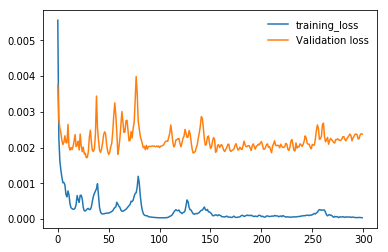

In [56]:
plt.plot(train_loss_l, label="training_loss")
plt.plot(test_loss_l,label='Validation loss')
plt.legend(frameon=False)

In [ ]:
test= torch.from_numpy(test.values).float()
with torch.no_grad():
    model.eval()
    output= model.forword(test)